# **LSTM (Para Vs Original)**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_recall_fscore_support, multilabel_confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# Load the data
train_df = pd.read_csv('NonParajudgments.csv', encoding = "Latin-1")
test_df = pd.read_csv('Parajudgments.csv', encoding = "Latin-1")
# Separating features and labels
train_df_X = train_df['Head_Notes']
train_df_y = train_df.drop(columns=['Head_Notes', 'Case_id', 'Ss'])

# Separating features and labels
test_df_X = test_df['Head_Notes']
test_df_y = test_df.drop(columns=['Head_Notes', 'Case_id', 'Ss'])


# # Assume 'Head_Notes' is the column with the text and other columns are the labels
# text_column = 'Head_Notes'
# label_columns = ['Murder', 'Dacoity', 'Rape', 'Fraud', 'Robbery or Theft', 'Kidnapp']

# # Combine the datasets for consistent preprocessing
# combined_df = pd.concat([train_df, test_df])

In [4]:
# # Preprocessing function (example)
# def preprocess_text(text):
#     # Implement text preprocessing (tokenization, lowercasing, etc.)
#     return text

# combined_df[text_column] = combined_df[text_column].apply(preprocess_text)

# # Convert text to sequences
# tokenizer = get_tokenizer("basic_english")
# vocab = build_vocab_from_iterator(map(tokenizer, combined_df[text_column]), specials=["<unk>"])
# vocab.set_default_index(vocab["<unk>"])

# def text_pipeline(text):
#     return vocab(tokenizer(text))

# def collate_batch(batch):
#     text_list, label_list = [], []
#     for _text, _labels in batch:
#         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
#         text_list.append(processed_text)
#         label_list.append(torch.tensor(_labels, dtype=torch.float32))
#     text_list = torch.nn.utils.rnn.pad_sequence(text_list, padding_value=0)
#     label_list = torch.stack(label_list)
#     return text_list, label_list
from sklearn.feature_extraction.text import CountVectorizer

# Tokenize and encode the datasets
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_train = vectorizer.fit_transform(train_df_X).toarray()  # Convert to dense format
X_test = vectorizer.transform(test_df_X).toarray()  # Convert to dense format

y_train = train_df_y.values
y_test = test_df_y.values

# Prepare datasets
class JudgementDataset(Dataset):
    def __init__(self, df, text_column, label_columns):
        self.df = df
        self.texts = df[text_column].values
        self.labels = df[label_columns].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [ ]:
# train_dataset = JudgementDataset(train_df_X, text_column, label_columns)
# test_dataset = JudgementDataset(test_df_X, text_column, label_columns)

# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_batch)
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_batch)
from torch.utils.data import DataLoader, TensorDataset, Dataset

# Prepare data loaders
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
test_dataset = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).float())

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # * 2 for bidirectional

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Extract the last hidden state output
        last_hidden_state = lstm_out[:, -1, :]
        out = self.fc(last_hidden_state)
        return out

In [ ]:
# Initialize the model, criterion, and optimizer
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 6  # Number of labels
model = LSTMClassifier(input_dim, hidden_dim, output_dim)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
EPOCHS = 4
train_losses = []
train_accuracies = []
val_losses = []
# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        optimizer.zero_grad()

        # Reshape inputs to (batch_size, sequence_length, input_dim)
        inputs = inputs.unsqueeze(1)  # Add sequence_length dimension
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate training accuracy
        predictions = (torch.sigmoid(outputs) >= 0.5).float()
        correct_predictions += (predictions == labels).float().sum()
        total_predictions += labels.numel()

    # Calculate average training loss and accuracy for the epoch
    average_loss = total_loss / len(train_loader)
    training_accuracy = correct_predictions / total_predictions

    # Append the values to the lists
    train_losses.append(average_loss)
    train_accuracies.append(training_accuracy.item())

    print(f'Epoch {epoch + 1}/{EPOCHS}, Average Training Loss: {average_loss}, Training Accuracy: {training_accuracy}')

Epoch 1: 100%|██████████| 14/14 [00:00<00:00, 15.69it/s]


Epoch 1/4, Average Training Loss: 0.6170491682631629, Training Accuracy: 0.7685185074806213


Epoch 2: 100%|██████████| 14/14 [00:00<00:00, 19.77it/s]


Epoch 2/4, Average Training Loss: 0.41717336220400675, Training Accuracy: 0.8734567761421204


Epoch 3: 100%|██████████| 14/14 [00:00<00:00, 17.20it/s]


Epoch 3/4, Average Training Loss: 0.2855875108923231, Training Accuracy: 0.9012345671653748


Epoch 4: 100%|██████████| 14/14 [00:00<00:00, 17.33it/s]

Epoch 4/4, Average Training Loss: 0.17570434936455318, Training Accuracy: 0.9614197611808777


In [ ]:
# Testing phase
model.eval()
total_test_loss = 0
correct_test_predictions = 0
total_test_predictions = 0

all_predictions = []
all_labels = []

test_losses = []  # List to store test losses for each batch

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.unsqueeze(1)  # Add sequence_length dimension
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        total_test_loss += loss.item()
        test_losses.append(loss.item())  # Store test loss for this batch

        # Calculate testing accuracy
        predictions = (torch.sigmoid(outputs) >= 0.43).float()
        correct_test_predictions += (predictions == labels).float().sum()
        total_test_predictions += labels.numel()

        all_predictions.append(predictions)
        all_labels.append(labels)

# Calculate average test loss and testing accuracy
average_test_loss = total_test_loss / len(test_loader)
testing_accuracy = correct_test_predictions / total_test_predictions

print(f'Test Loss: {average_test_loss}, Test Accuracy: {testing_accuracy}')


Test Loss: 0.18632176412003382, Test Accuracy: 0.9845678806304932


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Concatenate all predictions and labels
all_predictions = torch.cat(all_predictions).cpu().numpy()
all_labels = torch.cat(all_labels).cpu().numpy()

# Compute precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='micro')

print("Micro-averaged Precision:", precision)
print("Micro-averaged Recall:", recall)
print("Micro-averaged F1-score:", f1)

Micro-averaged Precision: 0.9923664122137404
Micro-averaged Recall: 0.935251798561151
Micro-averaged F1-score: 0.9629629629629629


# **SVM Code (Para VS Orig**)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [ ]:
# # Assume 'Head_Notes' is the column with the text and other columns are the labels
# text_column = 'Head_Notes'
# label_columns = ['Murder', 'Dacoity', 'Rape', 'Fraud', 'Robbery or Theft', 'Kidnapp']

# # Combine the datasets for consistent preprocessing
# combined_df = pd.concat([train_df, test_df])

# # Preprocessing function (example)
# def preprocess_text(text):
#     # Implement text preprocessing (tokenization, lowercasing, etc.)
#     return text.lower()

# combined_df[text_column] = combined_df[text_column].apply(preprocess_text)

# # Split the combined dataset back into training and testing sets
# train_df = combined_df.iloc[:len(train_df)]
# test_df = combined_df.iloc[len(train_df):]

In [ ]:
# Load the data
train_df = pd.read_csv('Parajudgments.csv', encoding = "Latin-1")
test_df = pd.read_csv('NonParajudgments.csv', encoding = "Latin-1")
# Separating features and labels
train_df_X = train_df['Head_Notes']
train_df_y = train_df.drop(columns=['Head_Notes', 'Case_id', 'Ss'])

# Separating features and labels
test_df_X = test_df['Head_Notes']
test_df_y = test_df.drop(columns=['Head_Notes', 'Case_id', 'Ss'])

In [ ]:
# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_df_X)
X_test = vectorizer.transform(test_df_X)

# Get the labels
y_train = train_df_y.values
y_test = test_df_y.values

# Initialize the SVM classifier
svm_classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True))

In [ ]:
# Train the model
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_classifier.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.6388888888888888
Precision: 1.0
Recall: 0.6762589928057554
F1-Score: 0.8068669527896996


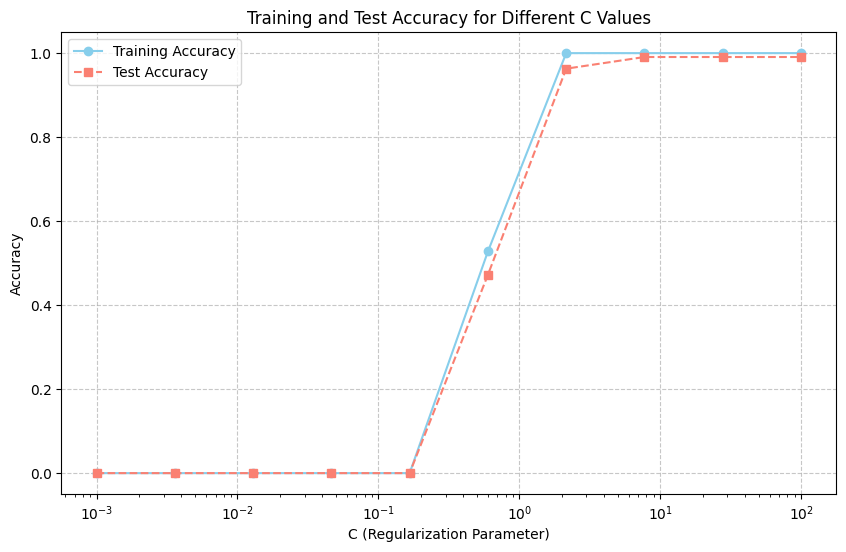

In [ ]:
# Plot Training and Test Scores
train_scores = []
test_scores = []
Cs = np.logspace(-3, 2, 10)

for C in Cs:
    svm_classifier = OneVsRestClassifier(SVC(kernel='linear', C=C, probability=True))
    svm_classifier.fit(X_train, y_train)
    train_score = svm_classifier.score(X_train, y_train)
    test_score = svm_classifier.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)

plt.figure(figsize=(10, 6))
plt.plot(Cs, train_scores, marker='o', label='Training Accuracy', color='skyblue', linestyle='-')
plt.plot(Cs, test_scores, marker='s', label='Test Accuracy', color='salmon', linestyle='--')
plt.xscale('log')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy for Different C Values')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# **DistilBERT model (Para VS Orig)**

In [5]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW

c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
train_df = pd.read_csv("NonParajudgments.csv", encoding = "Latin-1")
test_df = pd.read_csv("Parajudgments.csv", encoding = "Latin-1")

In [18]:
# Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Define the model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)
model.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [19]:
# Separating features and labels
train_data = train_df['Head_Notes']
train_labels = train_df.drop(columns=['Head_Notes', 'Case_id', 'Ss'])

test_data = test_df['Head_Notes']
test_labels = test_df.drop(columns=['Head_Notes', 'Case_id', 'Ss'])

In [21]:
# Define hyperparameters
MAX_LENGTH = 512
BATCH_SIZE = 8
LEARNING_RATE = 2e-5

class LegalJudgementsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx].clone().detach()
        return item

    def __len__(self):
        return len(self.labels)

In [22]:
# Tokenize and encode the datasets
train_encodings = tokenizer(list(train_data), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
test_encodings = tokenizer(list(test_data), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")

# Extract labels from the datasets
train_labels = torch.tensor(train_labels.values, dtype=torch.float32)
test_labels = torch.tensor(test_labels.values, dtype=torch.float32)

In [23]:
train_dataset = LegalJudgementsDataset(train_encodings, train_labels)
test_dataset = LegalJudgementsDataset(test_encodings, test_labels)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [24]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

def compute_accuracy(preds, labels):
    preds = torch.sigmoid(preds).round()
    correct = (preds == labels).float()
    acc = correct.sum() / correct.numel()
    return acc

c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
train_losses = []
train_accuracies = []

EPOCHS = 8
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    total_train_acc = 0
    for batch in tqdm(train_loader, desc="Epoch " + str(epoch + 1)):
        optimizer.zero_grad()
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_acc += compute_accuracy(outputs.logits, labels).item()

    average_train_loss = total_train_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{EPOCHS}, Average Training Loss: {average_train_loss}')
    average_train_acc = total_train_acc / len(train_loader)
    print(f'Epoch {epoch + 1}/{EPOCHS}, Average Training Accuracy: {average_train_acc}')

    train_losses.append(average_train_loss)
    train_accuracies.append(average_train_acc)

Epoch 1:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 14/14 [04:01<00:00, 17.25s/it]


Epoch 1/8, Average Training Loss: 0.6418831476143428
Epoch 1/8, Average Training Accuracy: 0.7053571449858802


Epoch 2: 100%|██████████| 14/14 [04:24<00:00, 18.92s/it]


Epoch 2/8, Average Training Loss: 0.5314978467566627
Epoch 2/8, Average Training Accuracy: 0.7797618976661137


Epoch 3: 100%|██████████| 14/14 [04:23<00:00, 18.84s/it]


Epoch 3/8, Average Training Loss: 0.4985545937504087
Epoch 3/8, Average Training Accuracy: 0.7842261961528233


Epoch 4: 100%|██████████| 14/14 [04:24<00:00, 18.92s/it]


Epoch 4/8, Average Training Loss: 0.47698206986699787
Epoch 4/8, Average Training Accuracy: 0.7976190532956805


Epoch 5: 100%|██████████| 14/14 [03:46<00:00, 16.21s/it]


Epoch 5/8, Average Training Loss: 0.4484324391399111
Epoch 5/8, Average Training Accuracy: 0.8095238123621259


Epoch 6: 100%|██████████| 14/14 [03:37<00:00, 15.57s/it]


Epoch 6/8, Average Training Loss: 0.4151774133954729
Epoch 6/8, Average Training Accuracy: 0.8511904776096344


Epoch 7: 100%|██████████| 14/14 [03:36<00:00, 15.47s/it]


Epoch 7/8, Average Training Loss: 0.37592586662088123
Epoch 7/8, Average Training Accuracy: 0.8645833347524915


Epoch 8: 100%|██████████| 14/14 [03:33<00:00, 15.25s/it]

Epoch 8/8, Average Training Loss: 0.32640326023101807
Epoch 8/8, Average Training Accuracy: 0.9002976162093026


In [26]:
model.eval()
total_accuracy = 0
num_batches = 0
predicted_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluation"):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.sigmoid(outputs.logits)

        # Thresholding predictions
        binary_predictions = (predictions > 0.4).int()

        # Calculate accuracy
        batch_accuracy = (binary_predictions == labels).float().mean().item()
        total_accuracy += batch_accuracy
        num_batches += 1

        # Append predicted labels for this batch
        predicted_labels.extend(binary_predictions.tolist())

print("Accuracy:", total_accuracy / num_batches)

# Convert the predicted labels list to a tensor
predicted_labels_tensor = torch.tensor(predicted_labels)

# Assuming your labels are in a list of lists format, convert to tensor
actual_labels_tensor = torch.tensor(test_dataset.labels)

precision, recall, f1, _ = precision_recall_fscore_support(actual_labels_tensor.cpu(), predicted_labels_tensor.cpu(), average='micro')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
# Show the predicted labels for every instance
for idx, (predicted_label, actual_label) in enumerate(zip(predicted_labels_tensor, actual_labels_tensor)):
    print(f"Instance {idx}:")
    print("Predicted Label:", predicted_label)
    print("Actual Label:", actual_label)

Evaluation: 100%|██████████| 14/14 [03:47<00:00, 16.25s/it]
C:\Users\ahmad\AppData\Local\Temp\ipykernel_18464\1444259844.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actual_labels_tensor = torch.tensor(test_dataset.labels)


Accuracy: 0.9285714285714286
Precision:  0.9196428571428571
Recall:  0.7410071942446043
F1 Score:  0.8207171314741036
Instance 0:
Predicted Label: tensor([1, 0, 0, 0, 0, 0])
Actual Label: tensor([1., 0., 0., 0., 0., 0.])
Instance 1:
Predicted Label: tensor([1, 0, 0, 0, 0, 0])
Actual Label: tensor([1., 0., 0., 0., 0., 0.])
Instance 2:
Predicted Label: tensor([1, 0, 0, 0, 0, 0])
Actual Label: tensor([1., 0., 0., 0., 0., 0.])
Instance 3:
Predicted Label: tensor([1, 0, 0, 0, 0, 0])
Actual Label: tensor([1., 0., 0., 0., 0., 0.])
Instance 4:
Predicted Label: tensor([1, 0, 0, 0, 0, 0])
Actual Label: tensor([1., 0., 0., 0., 0., 0.])
Instance 5:
Predicted Label: tensor([1, 0, 0, 0, 0, 0])
Actual Label: tensor([1., 0., 0., 0., 0., 0.])
Instance 6:
Predicted Label: tensor([1, 0, 0, 0, 0, 0])
Actual Label: tensor([1., 0., 0., 0., 0., 0.])
Instance 7:
Predicted Label: tensor([1, 0, 0, 0, 0, 0])
Actual Label: tensor([1., 0., 0., 0., 0., 0.])
Instance 8:
Predicted Label: tensor([1, 0, 0, 0, 0, 0])
Ac